# Experiments with GalSim and SExtractor, Part 2

This notebook shows how to reproduce the experiments in *Approximate Inference for Constructing Astronomical Catalogs from Images* using the [Celeste.jl](https://github.com/jeff-regier/Celeste.jl) package and Julia 0.6.4. To install Celeste, run
```
Pkg.update()
Pkg.add("Celeste")
```

In [1]:
Pkg.status("Celeste")

 - Celeste                       0.4.0+             master (dirty)


In [2]:
import Celeste: AccuracyBenchmark, ParallelRun, GalsimBenchmark, Config, Model
using DataFrames
import PyPlot

In [3]:
extensions = AccuracyBenchmark.read_fits("three_sources_two_overlap.fits");

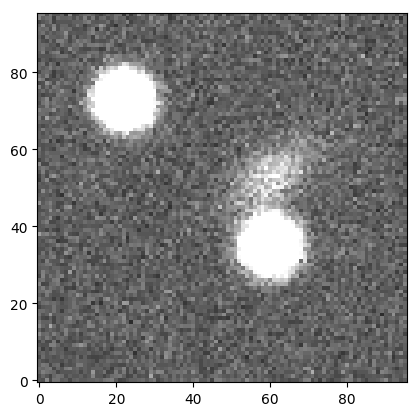

In [4]:
import PyPlot

data = extensions[2].pixels'
m, s = mean(data), std(data)
PyPlot.imshow(data, interpolation="nearest", cmap="gray", vmin=m-s, vmax=m+s, origin="lower");

In [5]:
header = extensions[1].header
this_test_case_name = header["CLDESCR"]
num_sources = header["CLNSRC"]
images = AccuracyBenchmark.make_images(extensions)
truth_catalog_df = GalsimBenchmark.extract_catalog_from_header(header)
catalog_entries = AccuracyBenchmark.make_initialization_catalog(truth_catalog_df, false)
target_sources = collect(1:num_sources)
config = Config(min_radius_pix = 40.0)
patches = Model.get_sky_patches(images, catalog_entries)
neighbor_map = Dict(i=>Model.find_neighbors(patches, i) for i in target_sources);

In [6]:
results = ParallelRun.one_node_joint_infer(catalog_entries,
                                           patches,
                                           target_sources,
                                           neighbor_map,
                                           images,
                                           config=config)
prediction_df = AccuracyBenchmark.celeste_to_df(results)

[1]<1> INFO: Optimizing 3 sources
[1]<1> INFO: Done assigning sources to threads for processing
[1]<1> INFO: Processing with dynamic connected components load balancing
[1]<1> INFO: Batch 1 - [62.6024]
[1]<1> INFO: Batch 1 avg threads idle: 0% (0.0 / 62.602421731)
[1]<1> INFO: Batch 1 - [10.6158]
[1]<1> INFO: Batch 1 avg threads idle: 0% (0.0 / 10.615800067)
[1]<1> INFO: Batch 1 - [11.011]
[1]<1> INFO: Batch 1 avg threads idle: 0% (0.0 / 11.010975387)
[1]<1> INFO: Total idle time: 0, Total sum of threads times: 84
[1]<1> INFO: 14:18:04.808: (active,inactive) pixels processed: (1547715,1039750)


,ra,dec,is_star,gal_frac_dev,gal_axis_ratio,gal_radius_px,gal_angle_deg,flux_r_nmgy,color_ug,color_gr,color_ri,color_iz,log_flux_r_stderr,color_ug_stderr,color_gr_stderr,color_ri_stderr,color_iz_stderr
1,0.00393549,0.00671389,0.994661,0.0536154,0.0835272,0.102263,2.79257,39.6173,1.42809,0.637701,0.268736,0.162903,0.0100046,0.017783,0.0100867,0.0100084,0.0100178
2,0.00584556,0.00671389,0.00500033,0.0100033,0.234489,3.86712,36.4462,10.2129,0.240344,0.683427,0.319761,0.254095,0.0100077,0.0247784,0.0160226,0.0100143,0.0100442
3,0.00811397,0.00254722,0.994465,0.17972,0.320834,0.221562,129.211,40.0516,1.38968,0.635956,0.273009,0.15709,0.0100051,0.0169531,0.0100649,0.010009,0.0100176
